🔹 DATA_DIR_IN:  E:\MLME\Final1\Beat-the-Felix
🔹 DATA_DIR_OUT: E:\MLME\Final1\Results\Beat-the-Felix-Results
🔹 MODEL_DIR:    E:\MLME\Final1\Results


C:\Users\tej31\AppData\Local\Temp\ipykernel_7524\501459314.py:69: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\tej31\AppData\Local\Temp\ipykernel_7524\501459314.py:85: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\tej31\AppData\Local\Temp\ipykernel_7524\501459314.py:85: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\tej31\AppData\Local\Temp\ipykernel_7524\501459314.py:85


Cluster 0 full-test metrics:


,MSE,MAE,R2
State,,,
c,1.727471e-07,0.000219,0.972889
T_PM,6.837898e-02,0.161979,0.980364
d10,5.700790e-12,0.000002,0.988282
d50,5.307311e-12,0.000002,0.988370
d90,6.379602e-12,0.000002,0.989139
T_TM,7.911848e-02,0.129065,0.978668


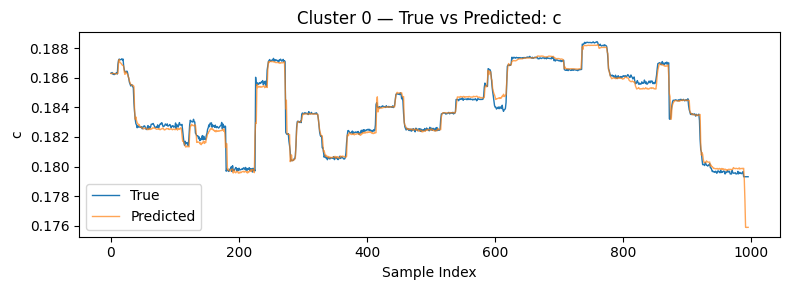

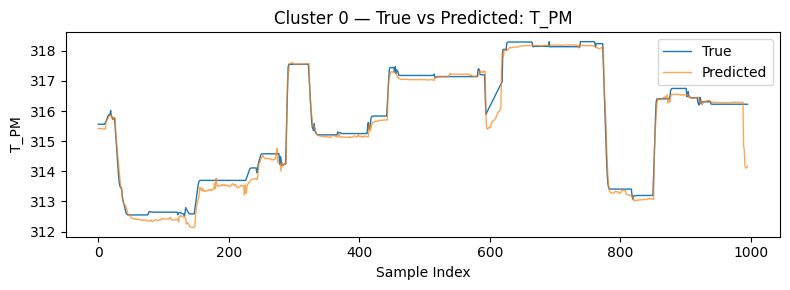

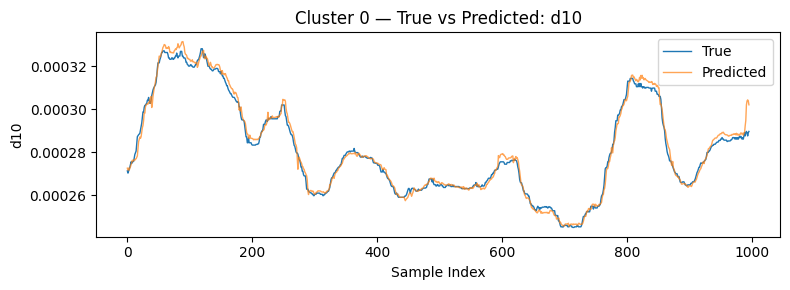

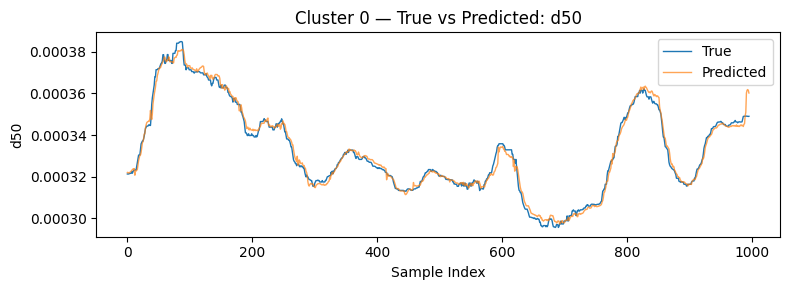

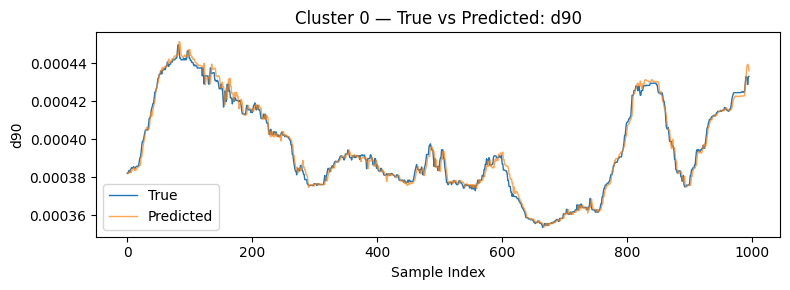

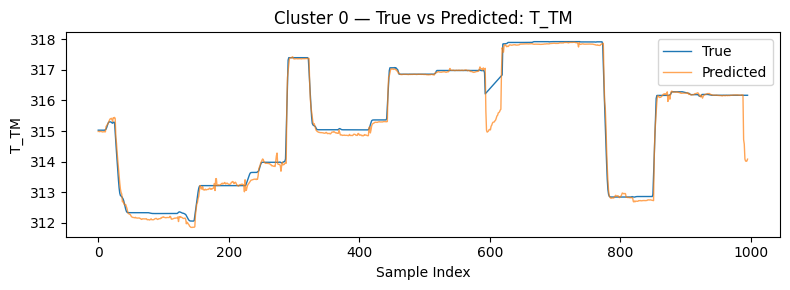

--- Completed visualization for cluster 0 ---


In [4]:
import os
import glob
import re
import joblib

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os
from pathlib import Path

# 1) Determine repository root (where this notebook lives)
BASE_DIR = Path().resolve()

# 2) Default input and output directories (relative to repo)
DEFAULT_IN  = BASE_DIR / "Beat-the-Felix"
DEFAULT_OUT = BASE_DIR / "Results"/ "Beat-the-Felix-Results"

# 3) Allow environment overrides
DATA_DIR_IN  = Path(os.getenv("MLME_DATA_IN",  DEFAULT_IN))
DATA_DIR_OUT = Path(os.getenv("MLME_DATA_OUT", DEFAULT_OUT))

# 4) Create output directory if it doesn't exist
DATA_DIR_OUT.mkdir(parents=True, exist_ok=True)

# Define model directory (where checkpoints and clustering results are stored)
MODEL_DIR = BASE_DIR / "Results"

# 5) Report settings
print(f"🔹 DATA_DIR_IN:  {DATA_DIR_IN}")
print(f"🔹 DATA_DIR_OUT: {DATA_DIR_OUT}")
print(f"🔹 MODEL_DIR:    {MODEL_DIR}")

# ── CONFIG ───────────────────────────────────────────────────────────────────
TARGET_COLS = ["c","T_PM","d10","d50","d90","T_TM"]
INPUT_COLS  = ["mf_PM","mf_TM","Q_g","w_crystal","c_in","T_PM_in","T_TM_in"]
NA, NB     = 1, 3
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

# ── HELPER FUNCTIONS ─────────────────────────────────────────────────────────
def read_txt(fp):
    try:
        return pd.read_csv(fp, sep="\t")
    except:
        return pd.read_csv(fp, delim_whitespace=True)


def build_narx(df):
    maxlag = max(NA, NB)
    Xs, Ys = [], []
    for t in range(maxlag, len(df)-1):
        py = df[TARGET_COLS].iloc[t-NA:t].values[::-1].reshape(-1)
        pu = df[INPUT_COLS].iloc[t-NB:t].values[::-1].reshape(-1)
        Xs.append(np.hstack([py, pu]))
        Ys.append(df[TARGET_COLS].iloc[t+1].values)
    return np.array(Xs, np.float32), np.array(Ys, np.float32)


def rolling_median_filter(df, cols, window=50):
    df_filtered = df.copy()
    for col in cols:
        if col in df_filtered.columns:
            df_filtered[col] = df_filtered[col].rolling(window=window, center=True, min_periods=1).median()
            df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    return df_filtered


def rolling_iqr_filter(df, cols, window=150, factor=1.5):
    df_filtered = df.copy()
    for col in cols:
        if col not in df_filtered.columns:
            continue
        q1 = df_filtered[col].rolling(window, center=True, min_periods=1).quantile(0.25)
        q3 = df_filtered[col].rolling(window, center=True, min_periods=1).quantile(0.75)
        iqr = q3 - q1
        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        mask = (df_filtered[col] < lower) | (df_filtered[col] > upper)
        df_filtered.loc[mask, col] = np.nan
        df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    return df_filtered

class NARXNetReg(nn.Module):
    def __init__(self, d_in, d_out, H1=64, H2=32, H3=64, dropout=0.00458):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, H1), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(H1, H2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(H2, H3), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(H3, d_out)
        )
    def forward(self, x):
        return self.net(x)

# ── STEP 1: Load original KMeans clusterer and filtered experiment means ────────────────────
exp_means_fp = os.path.join(MODEL_DIR, "experiment_column_means_filtered.csv")
df_means = pd.read_csv(exp_means_fp, index_col=0)
kmeans_path = os.path.join(MODEL_DIR, "kmeans.pkl")
if not os.path.isfile(kmeans_path):
    raise FileNotFoundError(f"KMeans model not found: {kmeans_path}")
kmeans = joblib.load(kmeans_path)
scaler_means = StandardScaler().fit(df_means.values)

# ── STEP 2: Assign new files to clusters ─────────────────────────────────────
txt_files = [os.path.join(root, fn)
             for root, _, files in os.walk(DATA_DIR_IN)
             for fn in files if fn.lower().endswith('.txt')]
rows, paths = [], []
for fp in txt_files:
    df = read_txt(fp)
    num_df = df.select_dtypes(include=[np.number])
    if num_df.empty:
        continue
    rows.append(num_df.mean())
    paths.append(fp)
df_new = pd.DataFrame(rows).fillna(0)
df_new = df_new.reindex(columns=df_means.columns, fill_value=0)
X_new = scaler_means.transform(df_new.values)
labels = kmeans.predict(X_new)
assign_df = pd.DataFrame({'path': paths, 'cluster': labels})

# ── STEP 3: Evaluate per cluster (entire cluster for testing) ─────────────────────────────
for cluster in sorted(assign_df['cluster'].unique()):
    ckpt_fp = os.path.join(MODEL_DIR, f"narx_cluster_{cluster}.pt")
    if not os.path.isfile(ckpt_fp):
        print(f"Cluster {cluster}: checkpoint missing, skip.")
        continue
    ckpt = torch.load(ckpt_fp, map_location=DEVICE, weights_only=False)
    xsc = StandardScaler(); xsc.mean_, xsc.scale_ = ckpt['x_mean'], ckpt['x_scale']
    ysc = StandardScaler(); ysc.mean_, ysc.scale_ = ckpt['y_mean'], ckpt['y_scale']
    model = NARXNetReg(len(xsc.mean_), len(TARGET_COLS)).to(DEVICE)
    model.load_state_dict(ckpt['model']); model.eval()

    paths_cl = assign_df.query('cluster==@cluster')['path'].tolist()
    Xs, Ys = [], []
    for fp in paths_cl:
        df = read_txt(fp)
        df = rolling_median_filter(df, ['d10','d50','d90'], window=50)
        df = rolling_iqr_filter(df, ['c','T_PM','T_TM'], window=150, factor=1.5)
        Xf, Yf = build_narx(df)
        if Xf.size:
            Xs.append(Xf); Ys.append(Yf)
    if not Xs:
        print(f"Cluster {cluster}: no valid data after feature build, skip.")
        continue
    X = np.vstack(Xs); Y_true = np.vstack(Ys)

    Xscl = xsc.transform(X)
    with torch.no_grad():
        pred = model(torch.from_numpy(Xscl).to(DEVICE)).cpu().numpy()
    Y_pred = ysc.inverse_transform(pred)

    # Display metrics inline
    metrics = []
    for i, state in enumerate(TARGET_COLS):
        yp, yt = Y_pred[:, i], Y_true[:, i]
        metrics.append({
            'State': state,
            'MSE': mean_squared_error(yt, yp),
            'MAE': mean_absolute_error(yt, yp),
            'R2': r2_score(yt, yp)
        })
    df_metrics = pd.DataFrame(metrics).set_index('State')
    print(f"\nCluster {cluster} full-test metrics:")
    display(df_metrics)

    # Inline visualization
    for i, state in enumerate(TARGET_COLS):
        plt.figure(figsize=(8, 3))
        plt.plot(Y_true[:, i], label="True", linewidth=1)
        plt.plot(Y_pred[:, i], label="Predicted", linewidth=1, alpha=0.7)
        plt.title(f"Cluster {cluster} — True vs Predicted: {state}")
        plt.xlabel("Sample Index"); plt.ylabel(state)
        plt.legend(); plt.tight_layout()
        plt.show()

    print(f"--- Completed visualization for cluster {cluster} ---")
